```@meta
CurrentModule = AlgorithmicRecourse 
```

# Generating recourse

To understand the core functionality of AlgorithmicRecourse.jl we will look at two example use cases of the `generate_recourse` function. This function takes a structure of type `Generator` as its main argument. Users can utilize one of the [default generators](#default-generators): `GenericGenerator <: Generator`, `GreedyGenerator <: Generator`. Alternatively, users can also create their own [custom generator](#custom-generators). 

```@docs
generate_recourse(generator::Generator, x̅::AbstractArray, 𝑴::Models.FittedModel, target::Float64, γ::Float64; T=1000)
```

## Default generators

Let $t\in\{0,1\}$ denote the target label, $M$ the model (classifier) and $\underline{x}\in\mathbb{R}^D$ the vector of counterfactual features. In order to generate recourse the `GenericGenerator` optimizes the following objective function through steepest descent

```math
\underline{x} = \arg \min_{\underline{x}}  \ell(M(\underline{x}),t) + \lambda h(\underline{x})
```

where $\ell$ denotes some loss function targeting the deviation between the target label and the predicted label and $h(\cdot)$ as a complexity penality generally addressing the *realism* or *cost* of the proposed counterfactual. 

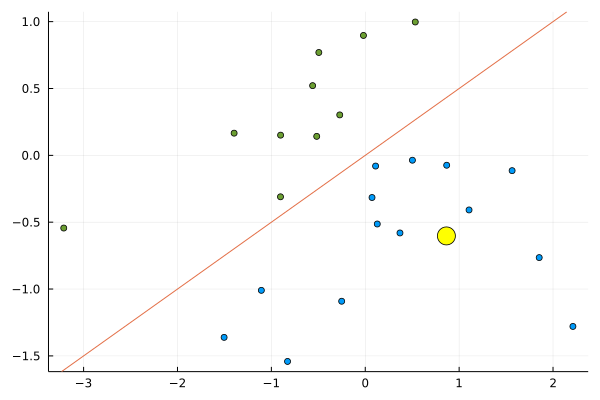

In [1]:
# Some random data:
using Flux
using Random
using Plots
Random.seed!(1234);
N = 25
w = reshape([1.0,-2.0],2,1) # true coefficients
b = 0
X = reshape(randn(2*N),N,2).*1 # random features
y = Int.(round.(Flux.σ.(X*w .+ b))); # label based on sigmoid
# Choose sample and plot:
x̅ = reshape(X[5,:],1,2)
scatter(X[:,1],X[:,2],legend=false,color=y) # features
Plots.abline!(-w[1]/w[2],0) # decision boundary
scatter!([x̅[1]],[x̅[2]],color="yellow",markersize=10)

In [3]:
# using AlgorithmicRecourse
# w = [1.0,-2.0] # true coefficients
# b = [0]
# x̅ = reshape([-1,0.5],1,2)
# target = 1.0
# γ = 0.9
# 𝑴 = AlgorithmicRecourse.Models.LogisticModel(w, b);
# generator = GenericGenerator(0.1,0.1,1e-5,:logitbinarycrossentropy,nothing)
# recourse = generate_recourse(generator, x̅, 𝑴, target, γ); # generate recourse